In [199]:
# imports
import csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os

In [200]:
def containsMarket(column, market=""):
    if market:
        return market in column
    return "am" in column or "sm" in column

def get_longform(df, key, agent_as_class=False):
    frames_col = get_frames_col(df)
    cols, agent_cols = extract_cols(df, key, agent_as_class)
    cols.insert(0,frames_col)
    # first create wideform
    df_wideform = df[cols].copy()
    # reshape dataframe into longform
    # lf = convert_to_longform(df_wideform, key, frames_col)
    lf = df_wideform.melt(id_vars=[frames_col], var_name="setting", value_name=key)
    lf.rename(columns={frames_col:'frames'}, inplace=True)
    return lf

def extract_cols(df, key, agent_as_class=False):
    result_cols = []
    agent_cols = []
    for col in df.columns:
        if key in col:
            if not "reward" in col:
                # always safe values
                result_cols.append(col)
            else:
                if "agent_0" in col:
                    # always safe agent 0 values
                    result_cols.append(col)
                if "mixed" in col or containsMarket(col):
                    if agent_as_class:
                        # create new col class (as seperate df col) for styling
                        agent_cols.append(col)
                    elif not "agent_0" in col:
                        # always add mixed or market values for each agent since they differ from each other
                        result_cols.append(col)
               
    return result_cols, agent_cols

def get_frames_col(df):
    for col in df.columns:
        if "frames" in col:
            # since frames don't differ between settings, but i.e. three agents probably 
            # needs more frames pick the column that has the most values
            # (for example check if the value of the last index is not NaN)
            last_value = df[col].iloc[-1]
            if not np.isnan(last_value):
                return col

In [201]:
# read all storage folders to extract training info, i.e. markets and save it to envs
try:
    training_folders = os.listdir('storage') 
except(FileNotFoundError):
    training_folders = []

envs = {}
# while iterating create a wideform dataframe of all csv files
df_settings_dict = {}

keys = ["mean_reward", "mean_grid_coloration_percentage", "mean_num_reset_fields", "mean_trades", "mean_num_frames_per_episode",  "fully_colored" ]
base_settings = ["dqn", "ppo", "mixed", "mixed-competitive", "percentage", "rooms","rooms-mixed","rooms-percentage","rooms-mixed-competitive"]
lf_settings_dicts = {}
lf_comparison_settings_dict = {}
for folder in training_folders:
    # agents = folder.split("-")[0]
    if not "-ppo" in folder and not "-dqn" in folder:
        continue
    
    envs[folder] = {}

    if containsMarket(folder, "am"):
        market = "am" + folder.split("-am")[1]
        envs[folder]["market"] = market  
    elif containsMarket(folder, "sm"):
        market = "sm" + folder.split("-sm")[1]
        envs[folder]["market"] = market
    else:
        if folder == "3-ppo" or folder == "1-ppo" or folder == "3-dqn" or folder == "1-dqn":
            envs[folder]["compare_with"] = [f for f in training_folders if folder in f]

    # read csv file (if it exists)
    try:
        df_settings_dict[folder] = pd.read_csv('storage/'+folder+'/log.csv')
        # add setting to the df columns
        df_settings_dict[folder].columns = [folder + "_" + str(col) for col in df_settings_dict[folder].columns]
        for key in keys:
            # if key == "mean_grid_coloration_percentage":
            #     print(df_settings_dict[folder][folder+"_"+key].head)
            #     print(key)
            index = folder+ "_" + key
            lf_settings_dicts[index] = get_longform(df_settings_dict[folder], key)
            
            if containsMarket(folder):
                #to be compared with base setting!
                base_setting = folder.split("-am")[0] if "-am" in folder else folder.split("-sm")[0]
                base_index = base_setting+ "_" + key
                lf_compare_with = get_longform(df_settings_dict[folder], key)
                lf_comparison_settings_dict[base_index] = lf_comparison_settings_dict[base_index].append(lf_compare_with, ignore_index=True)
            else:
                # create comparison longforms
                lf_comparison_settings_dict[index] = get_longform(df_settings_dict[folder], key)

    except:
        continue

# print(envs)
# print(lf_settings_dicts["1-dqn_mean_grid_coloration_percentage"].head())
# print(df_settings_dict["1-dqn"]["mean_grid_coloration_percentage"])
# join all dataframes (one per setting)
df = pd.concat([df for df in df_settings_dict.values()], axis=1)

In [202]:
durations = []
for col in df.columns:
    if ("-ppo" in col or "-dqn" in col) and "duration_in_seconds" in col:
        index = df[col].last_valid_index()
        duration = df.at[index,col]
        if duration >= 6000: # higher than 1 1/2 hours
            print(col + " with duration " + str(duration) + " in hours: " + str((duration/60)/60))
        durations.append(df.at[index,col])

print("overall duration in hours " + str((sum(durations)/60)/60)) #prints duration of all settings in hours

1-dqn-1_duration_in_seconds with duration 17788 in hours: 4.941111111111111
1-dqn-10_duration_in_seconds with duration 31676 in hours: 8.798888888888888
1-dqn-11_duration_in_seconds with duration 14487.0 in hours: 4.024166666666667
1-dqn-2_duration_in_seconds with duration 18469 in hours: 5.130277777777778
1-dqn-3_duration_in_seconds with duration 34208 in hours: 9.502222222222223
1-dqn-4_duration_in_seconds with duration 17248.0 in hours: 4.79111111111111
1-dqn-5_duration_in_seconds with duration 17402 in hours: 4.83388888888889
1-dqn-6_duration_in_seconds with duration 17445 in hours: 4.845833333333333
1-dqn-7_duration_in_seconds with duration 18794 in hours: 5.220555555555555
1-dqn-8_duration_in_seconds with duration 17732 in hours: 4.925555555555556
1-dqn-9_duration_in_seconds with duration 18111 in hours: 5.030833333333334
overall duration in hours 62.204166666666666


In [203]:
col = df.columns[0]
print(col.split("1-dqn-")[1])

1_update_count


Specs:
2_fully_colored:  batch 64  | target update 100.000 | replay size 700.000 | epsilon decay 400.000 +++
equals
9_fully_colored:  batch 64  | target update 100.000 | replay size 800.000 | epsilon decay 400.000 

5_fully_colored:  batch 64  | target update 100.000 | replay size 500.000 | epsilon decay 300.000 +++
equals
8_fully_colored:  batch 64  | target update 100.000 | replay size 700.000 | epsilon decay 300.000
2 == 8, nur epsilon decay langsamer bei 2


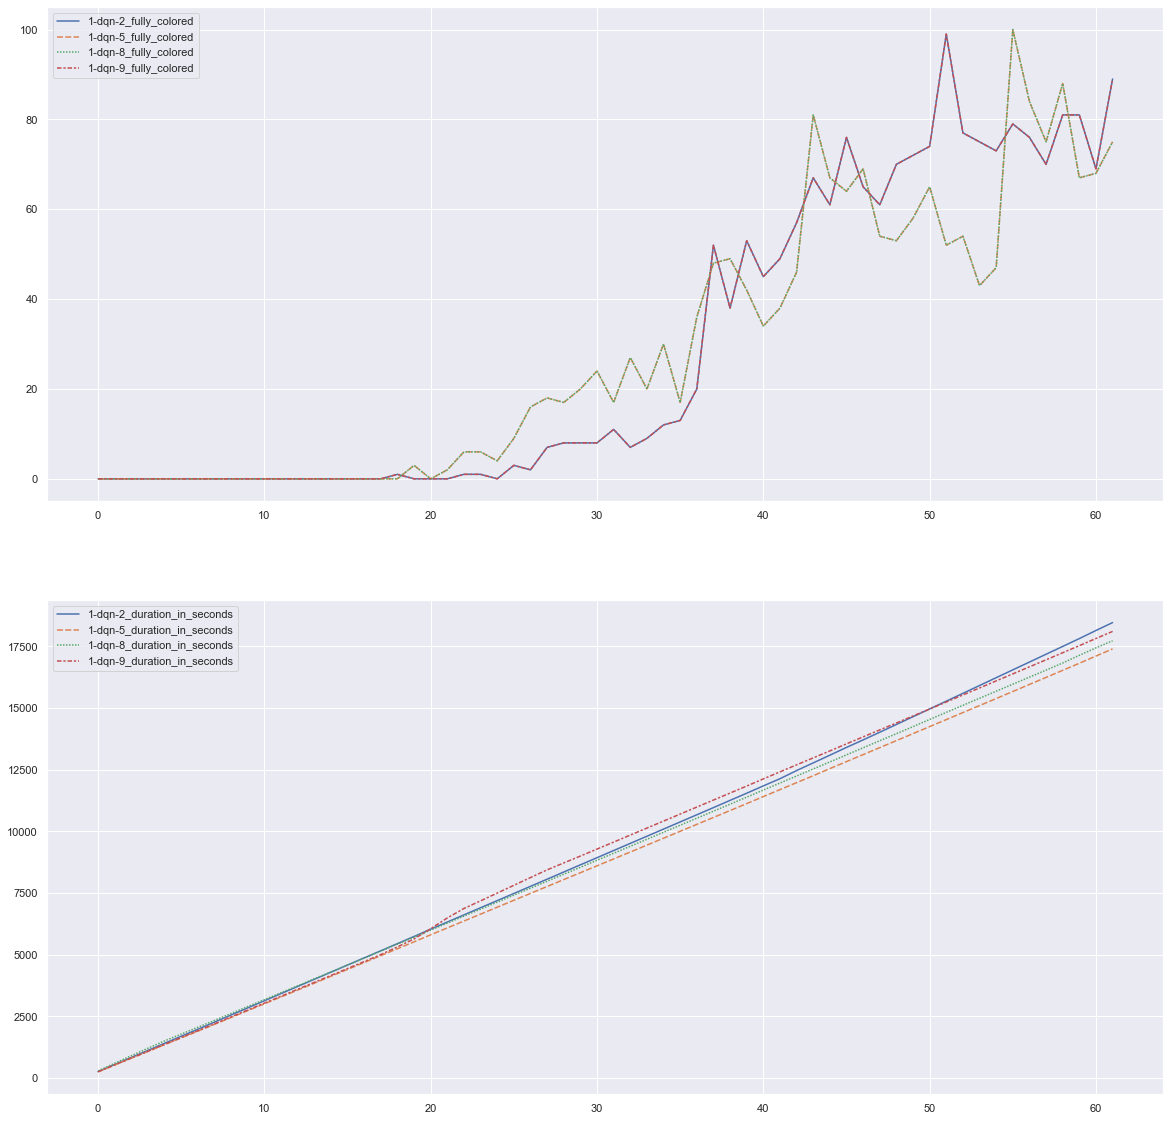

In [204]:

dqn_fully_colored = [col for col in df.columns if "fully_colored" in col and "dqn" in col if col.split("1-dqn-")[1][0] == "2" or  col.split("1-dqn-")[1][0] == "5" or col.split("1-dqn-")[1][0] == "8" or col.split("1-dqn-")[1][0] == "9"]

all_fully_colored = [col for col in df.columns if "fully_colored" in col]
all_durations = [col for col in df.columns if "duration" in col and "dqn" in col if col.split("1-dqn-")[1][0] == "2" or  col.split("1-dqn-")[1][0] == "5" or col.split("1-dqn-")[1][0] == "8" or col.split("1-dqn-")[1][0] == "9"]
# print([col for col in df.columns if "frames" in col])
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.lineplot(data=df[dqn_fully_colored], ax=axs[0])
# sns.lineplot(data=df[all_fully_colored], ax=axs[1])
sns.lineplot(data=df[all_durations], ax=axs[1])

print("Specs:")
# print("1_fully_colored:  batch 64  | target update 10.000  | replay size 700.000 | epsilon decay 400.000 ")

print("2_fully_colored:  batch 64  | target update 100.000 | replay size 700.000 | epsilon decay 400.000 +++")
print("equals")
print("9_fully_colored:  batch 64  | target update 100.000 | replay size 800.000 | epsilon decay 400.000 \n")

# print("3_fully_colored:  batch 128 | target update 70.000  | replay size 700.000 | epsilon decay 350.000")
# print("4_fully_colored:  batch 64  | target update 50.000  | replay size 700.000 | epsilon decay 350.000")
print("5_fully_colored:  batch 64  | target update 100.000 | replay size 500.000 | epsilon decay 300.000 +++")
print("equals")
print("8_fully_colored:  batch 64  | target update 100.000 | replay size 700.000 | epsilon decay 300.000")

print("2 == 8, nur epsilon decay langsamer bei 2")

# print("6_fully_colored:  batch 64  | target update 150.000 | replay size 500.000 | epsilon decay 300.000")
# print("7_fully_colored:  batch 64  | target update 200.000 | replay size 700.000 | epsilon decay 300.000")
# print("9_fully_colored:  batch 64  | target update 100.000 | replay size 800.000 | epsilon decay 400.000")
# print("10_fully_colored: batch 128 | target update 100.000 | replay size 700.000 | epsilon decay 400.000")
# print("11_fully_colored: batch 64  | target update 400.000 | replay size 700.000 | epsilon decay 400.000")
# print("12_fully_colored: batch 32  | target update 50.000  | replay size 700.000 | epsilon decay 400.000")
# print("13_fully_colored: batch 32  | target update 100.000 | replay size 100.000 | epsilon decay 400.000")

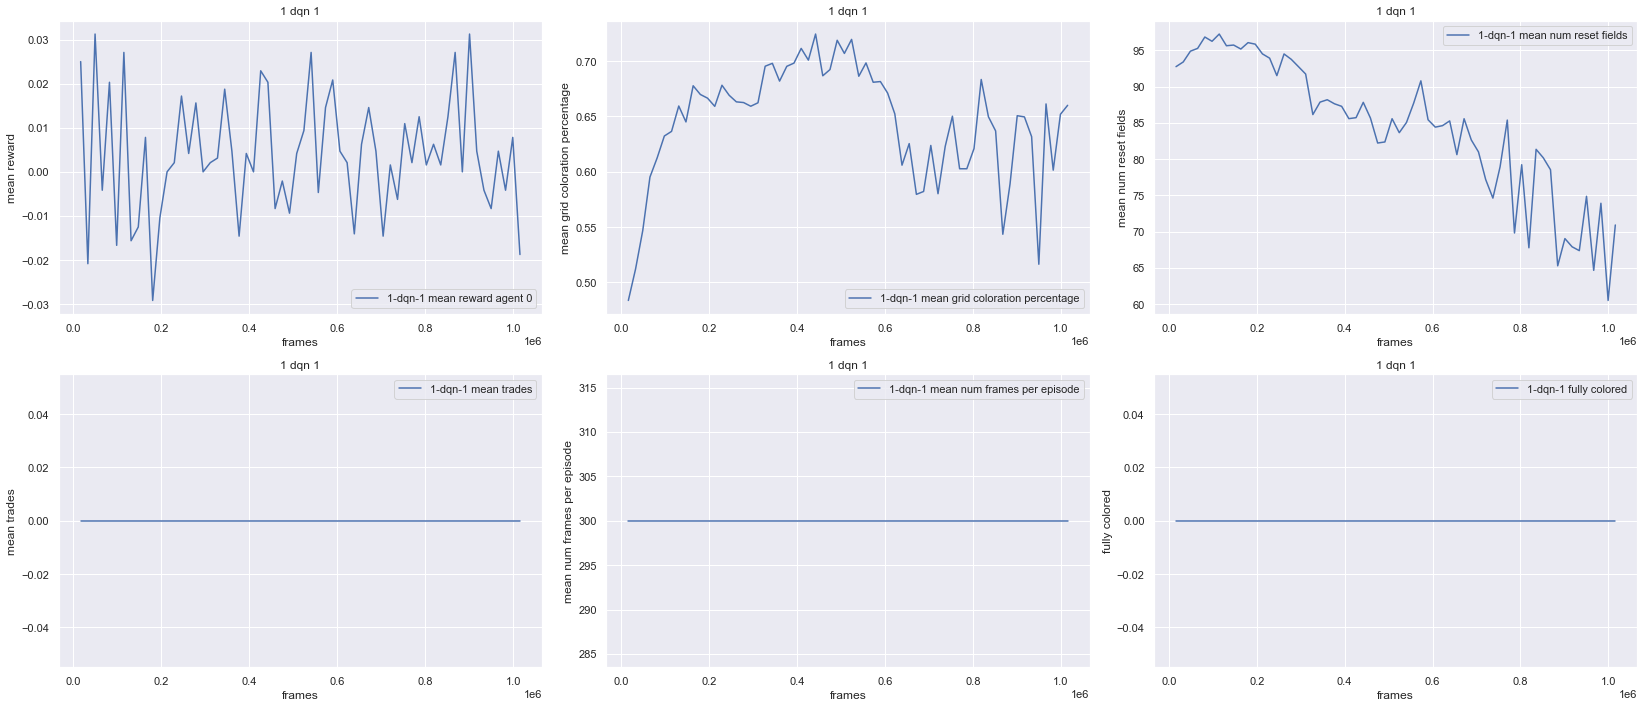

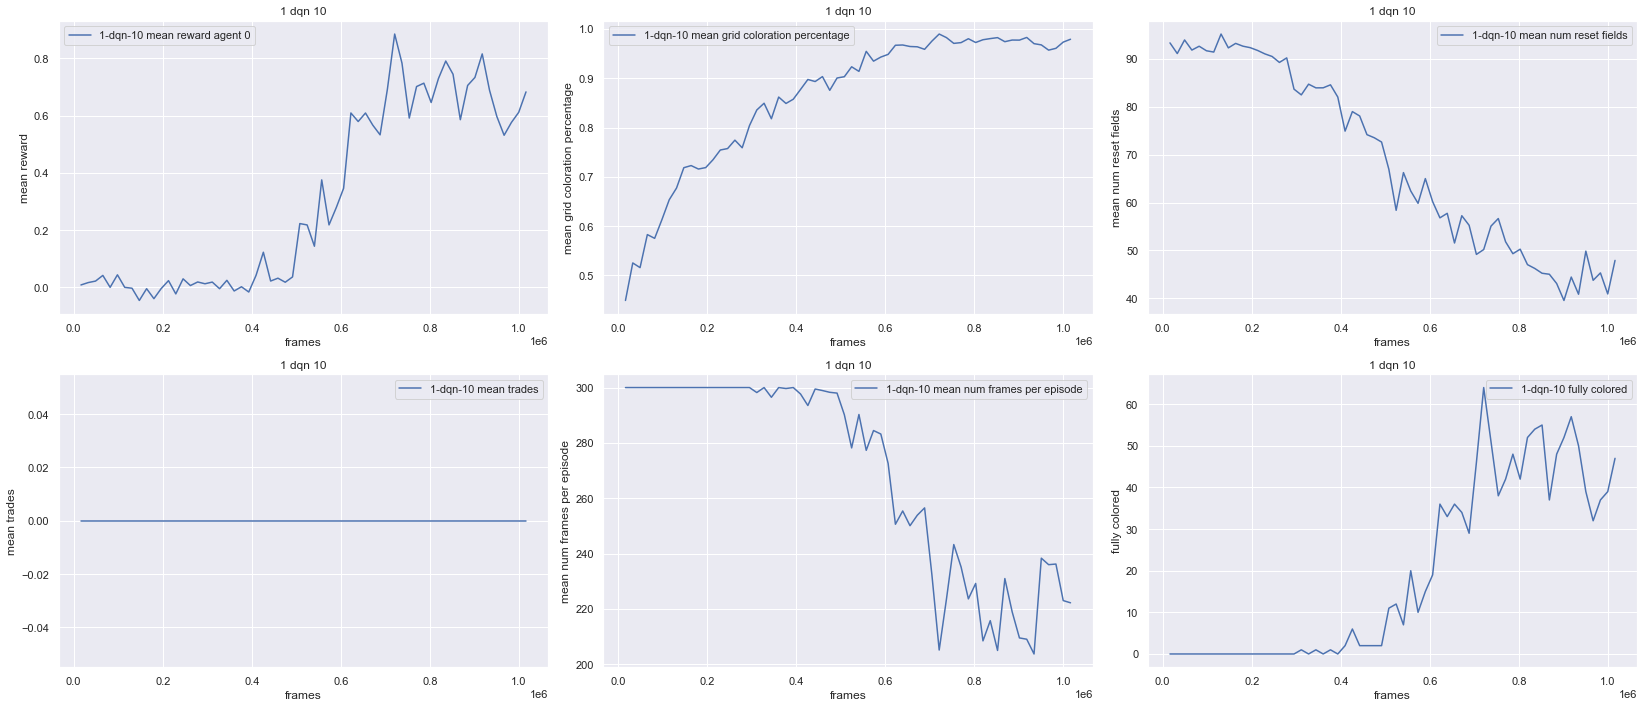

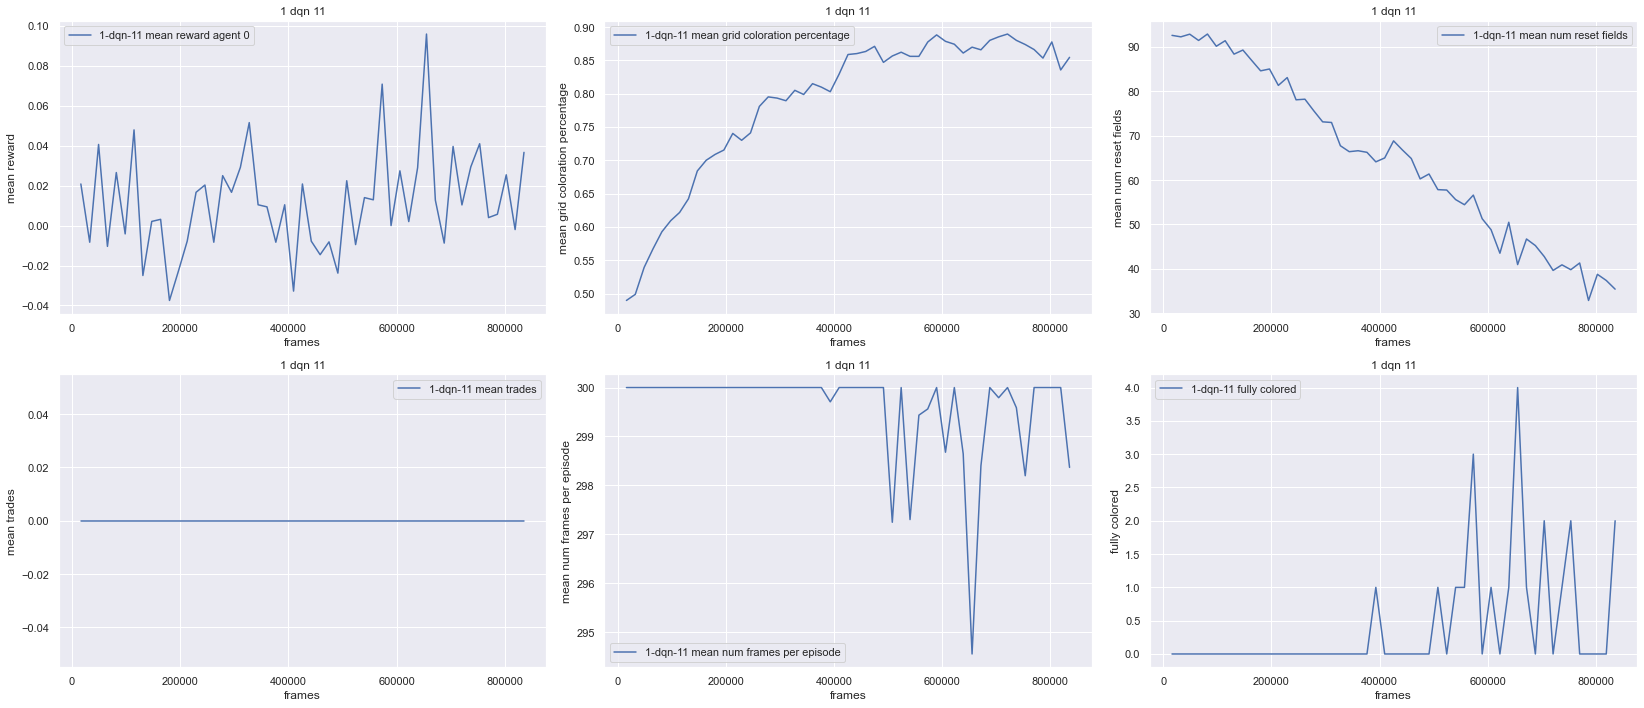

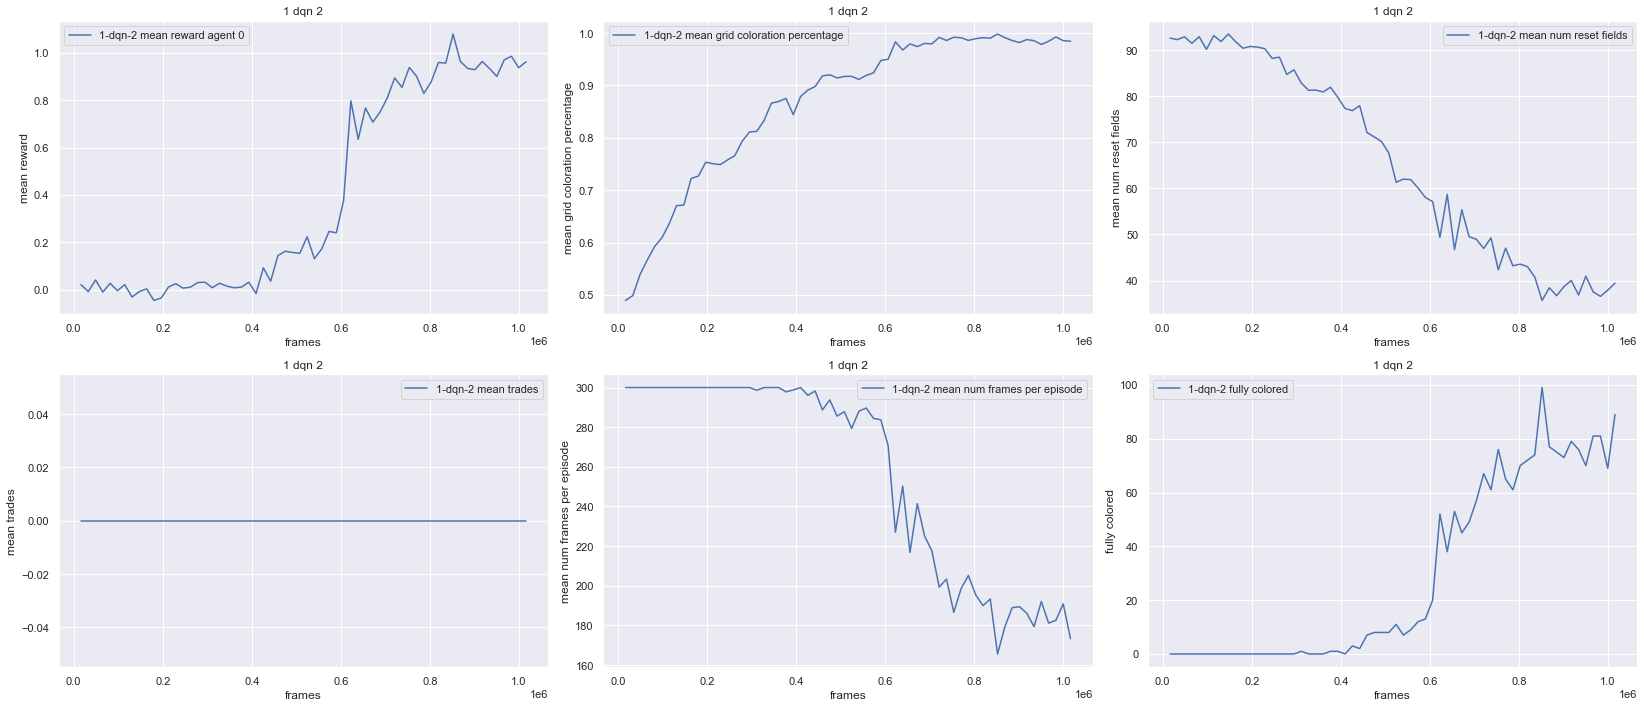

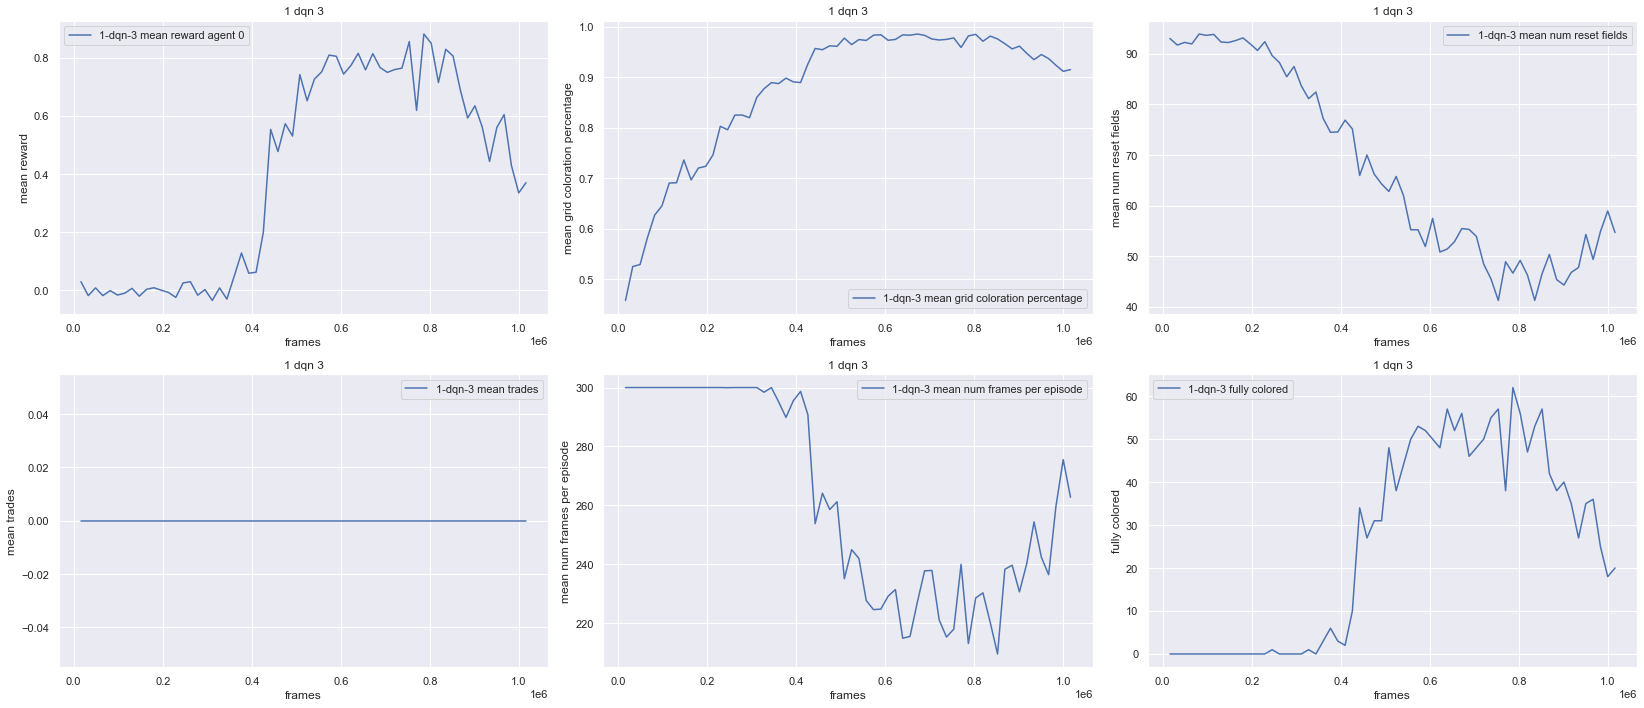

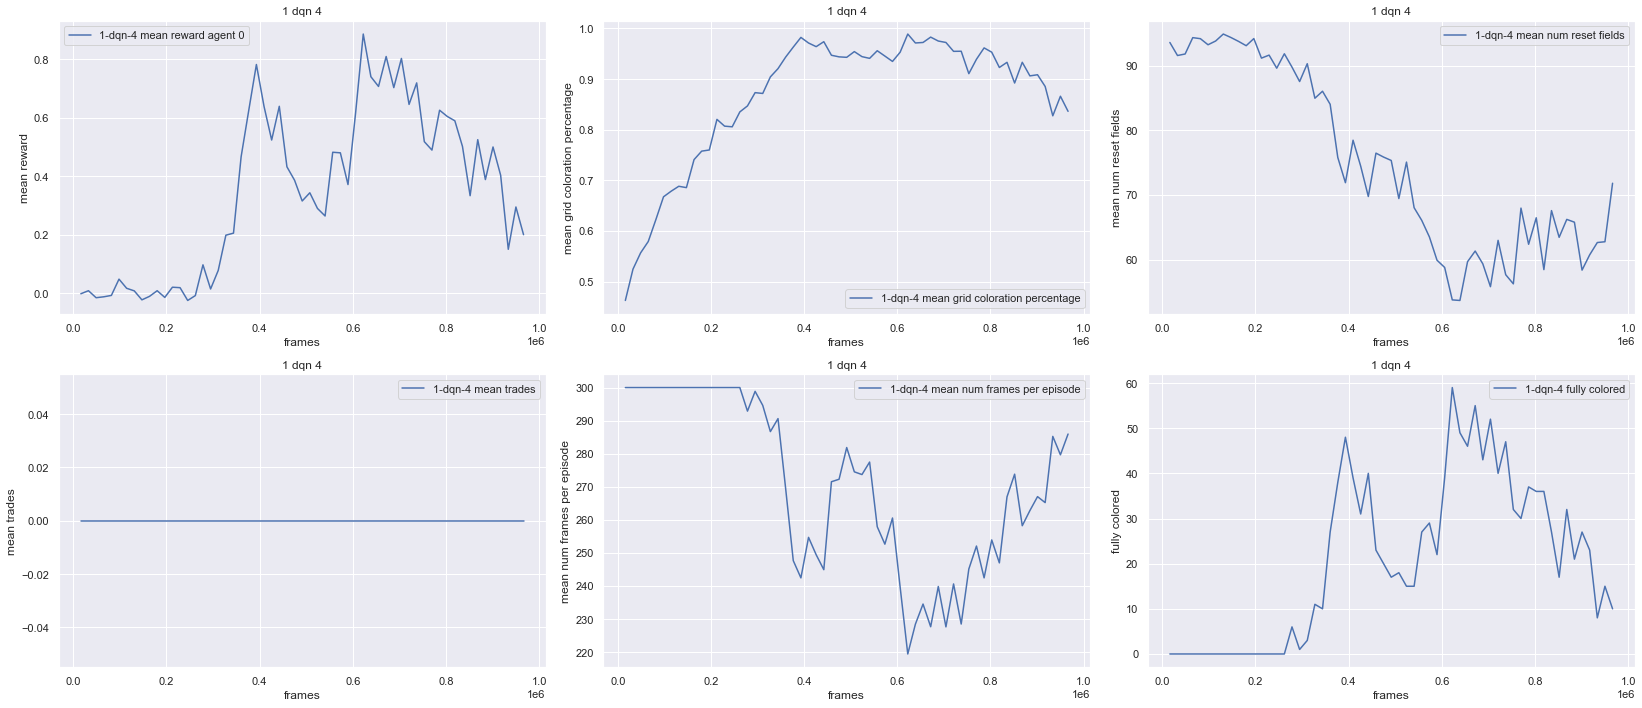

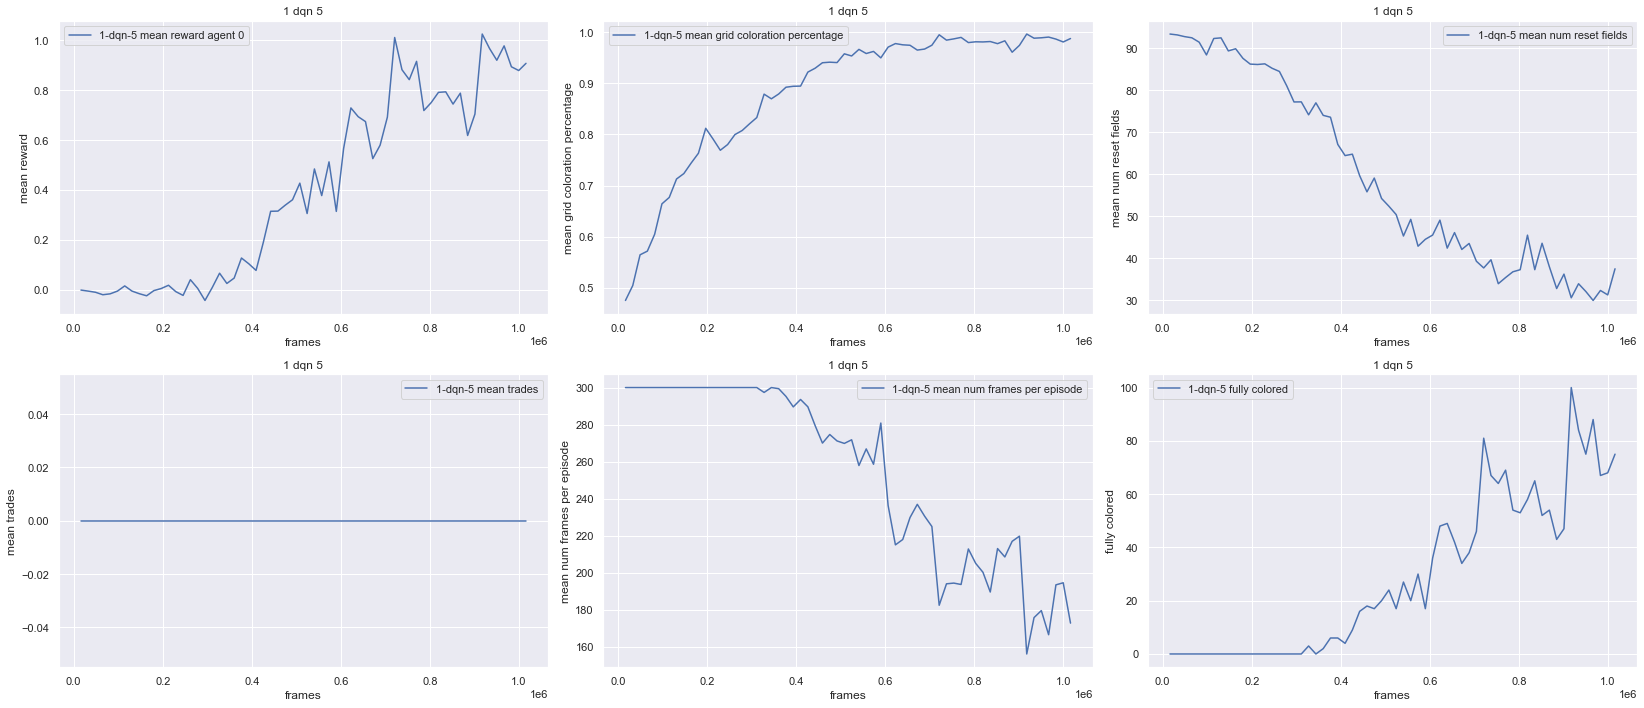

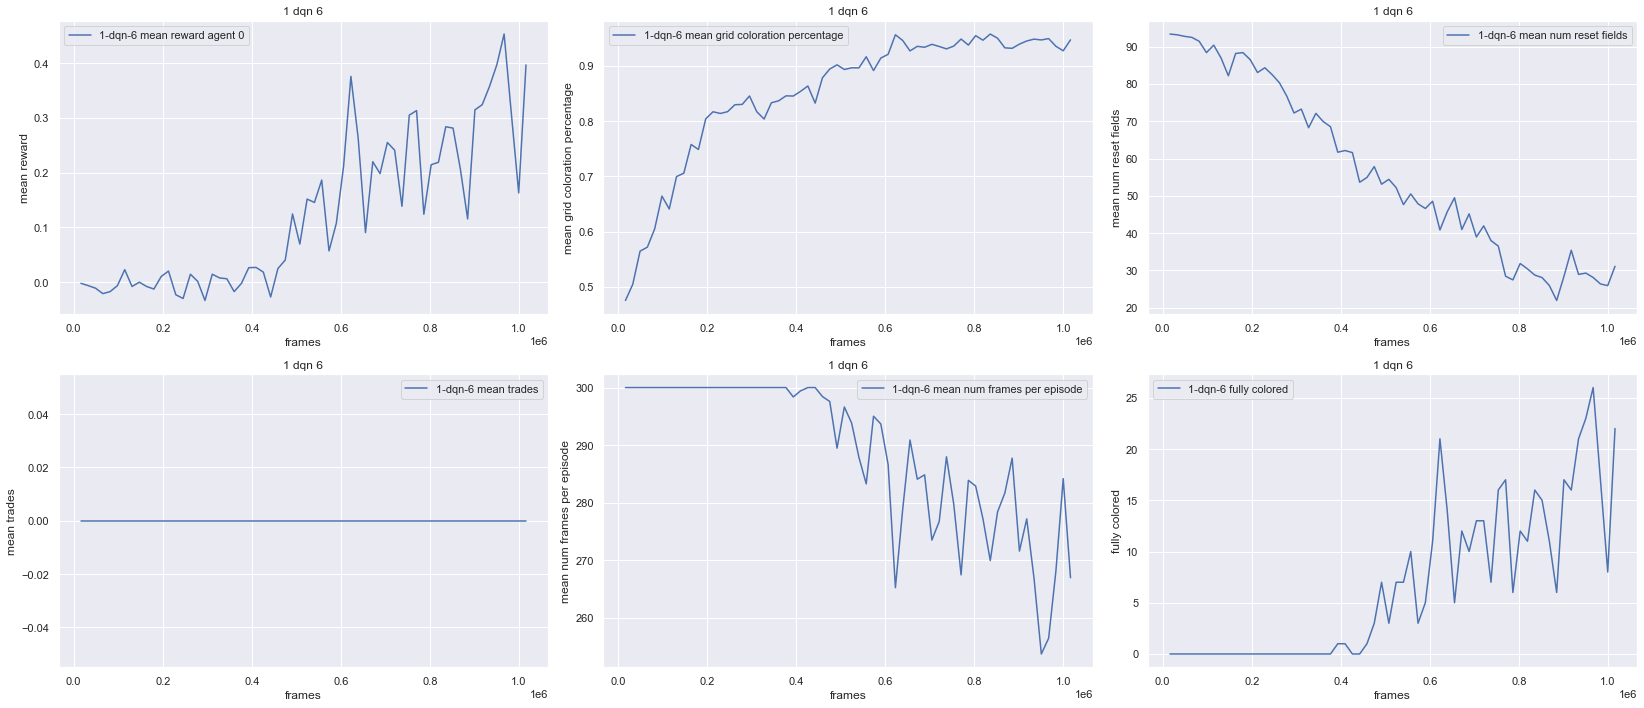

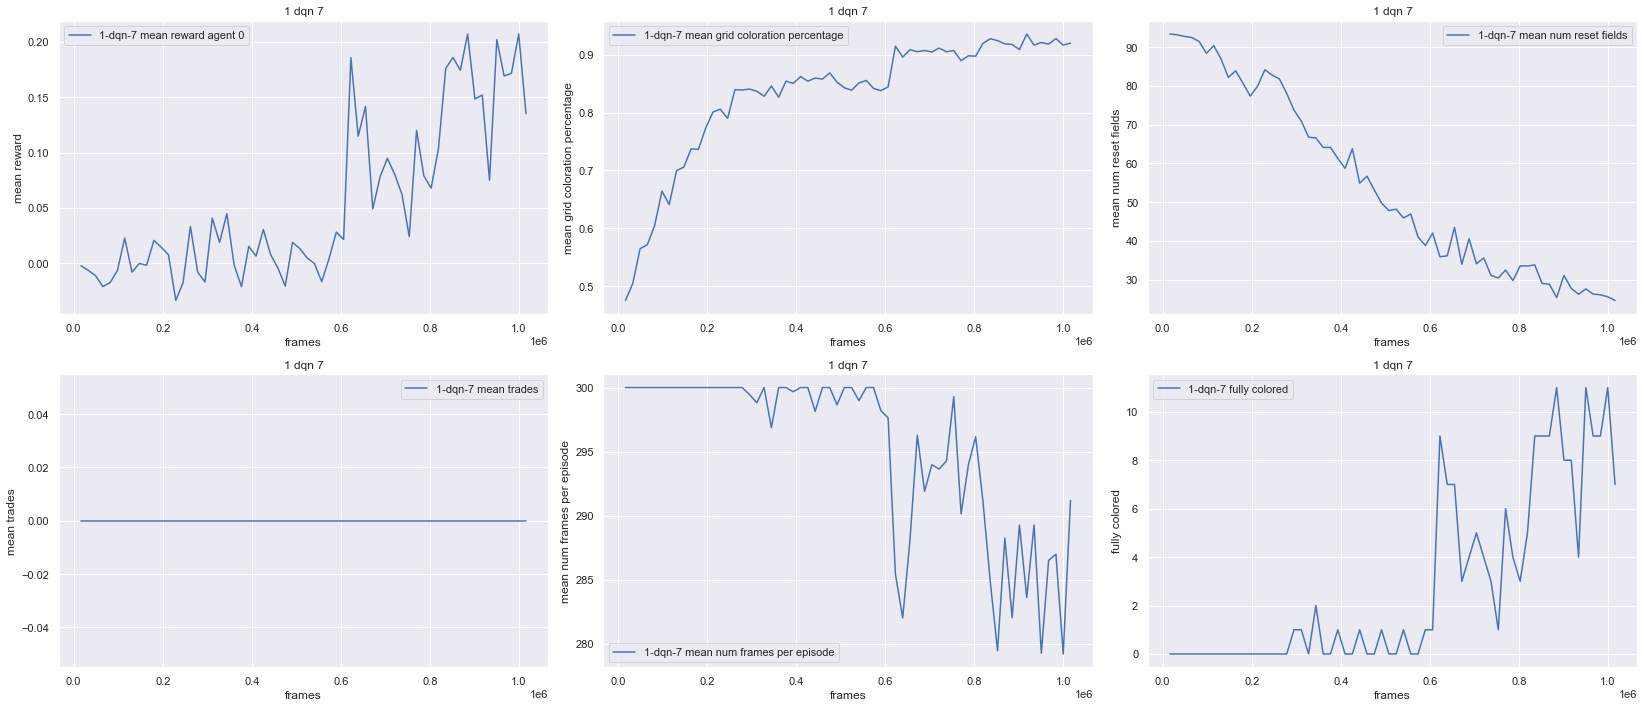

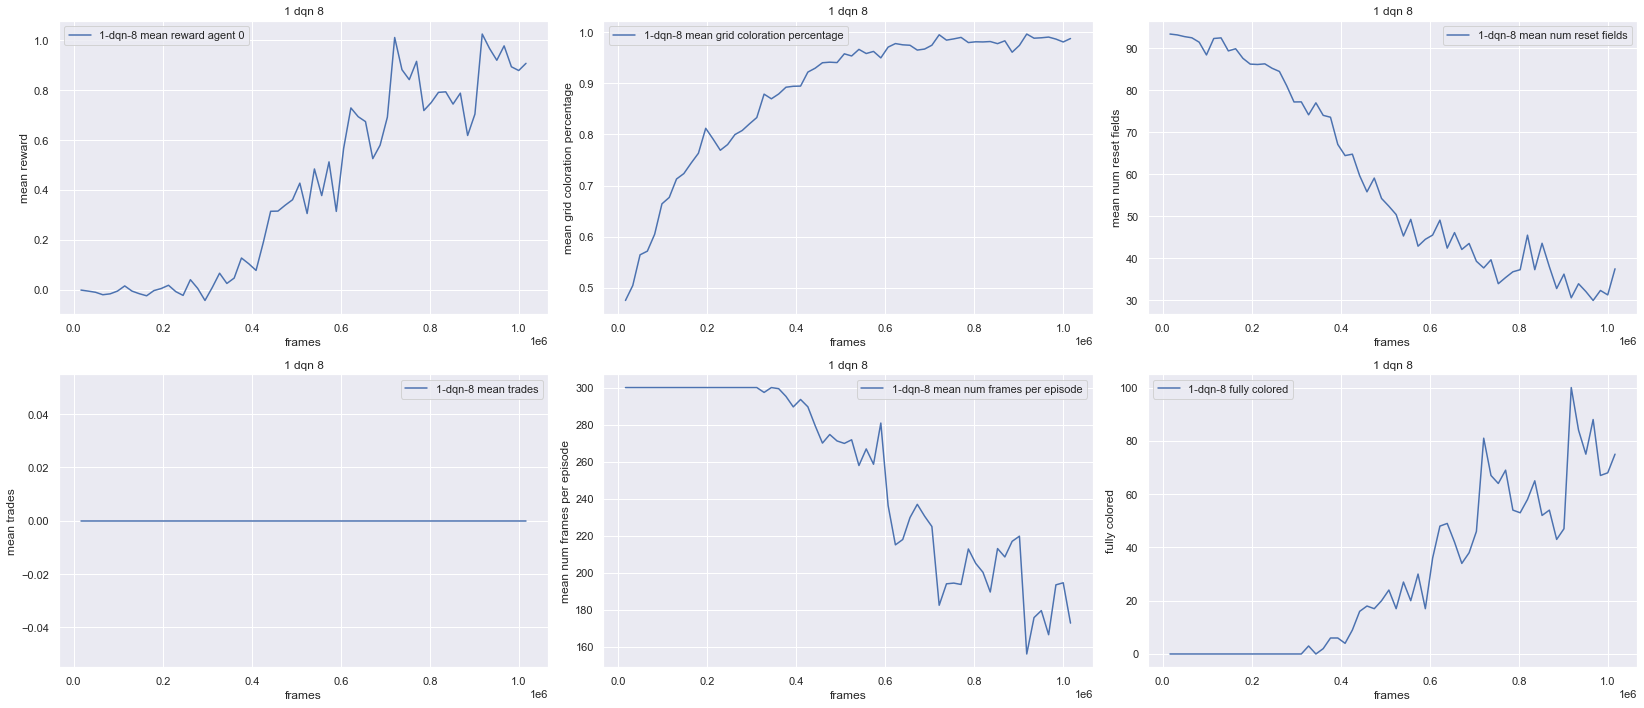

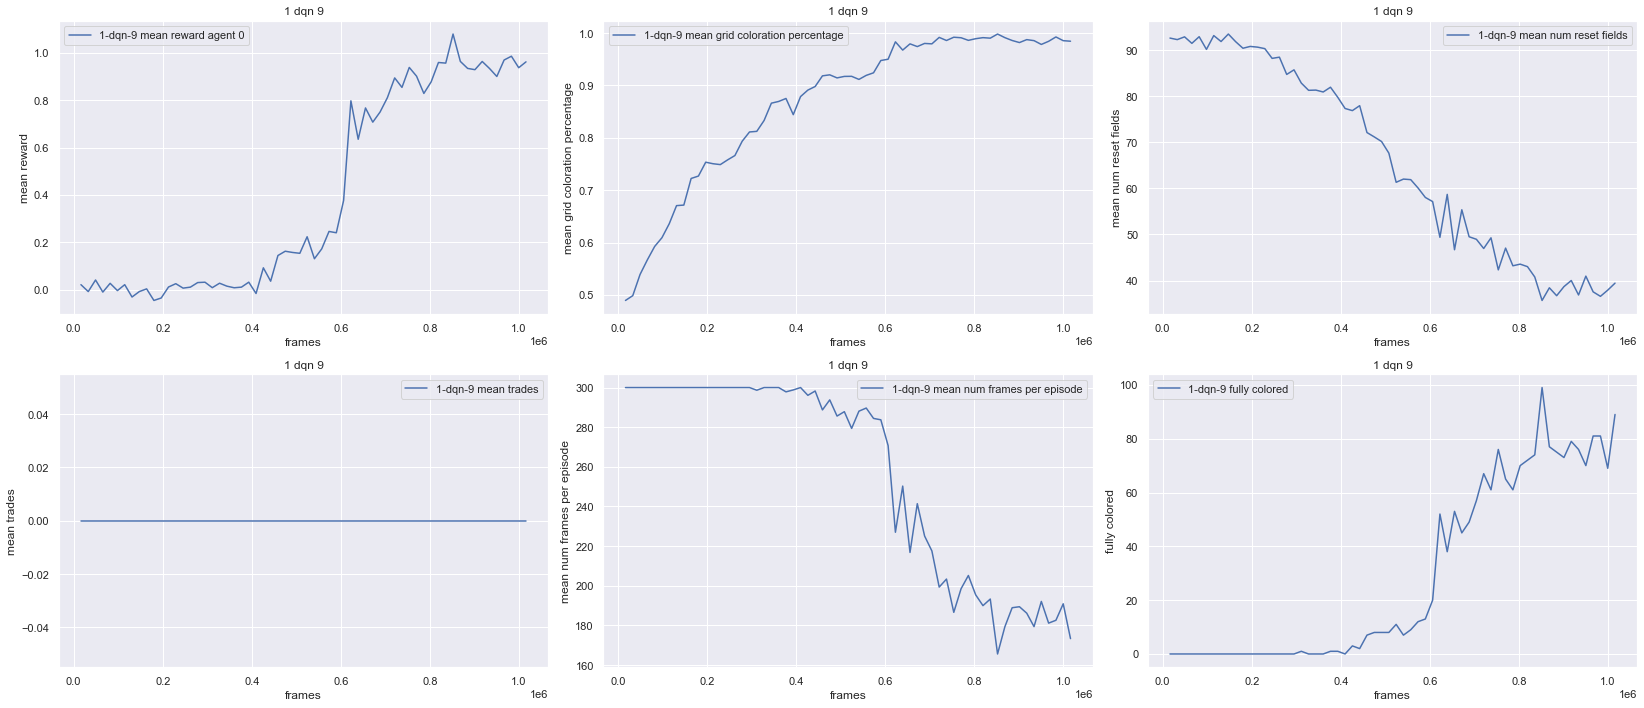

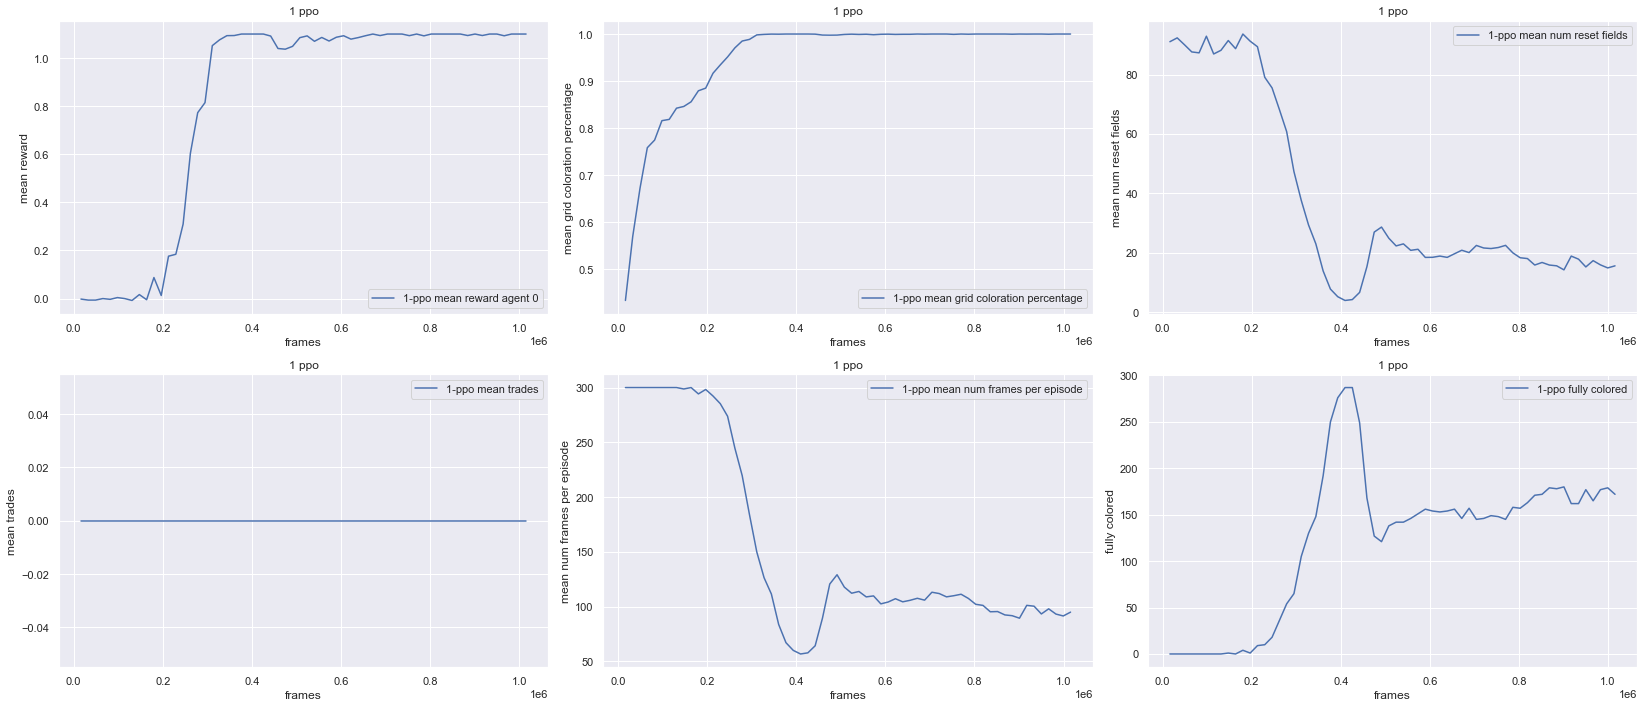

In [205]:
for setting in envs.keys():
    if containsMarket(setting):
        continue
    sns.set_palette("husl")
    sns.set_theme()
    #sns.set_palette("PuBuGn_d")
    #define how many subplots
    max_col = 3
    f, axes = plt.subplots(nrows=2, ncols=max_col, figsize=(23, 10)) #, sharex=True
    col = 0
    row = 0
    title = " ".join(setting.split("-"))
    for key in keys:
        y_label = " ".join(key.split("_"))
        g = sns.lineplot(data=lf_comparison_settings_dict[setting+"_"+key], x="frames", y=key, hue="setting", ax=axes[row, col])
        g.set(ylabel=y_label, title=title)

        #beatify plot legend labels
        _, labels = g.get_legend_handles_labels()
        for index, label in enumerate(labels):
            new_label = " ".join(label.split("_")).replace(title+" ", "")
            labels[index] = new_label
        g.legend(labels=labels)

        col += 1
        if col == max_col:
            row += 1
            col = 0

    # plt.setp(axes)
    plt.title(title)
    plt.tight_layout()

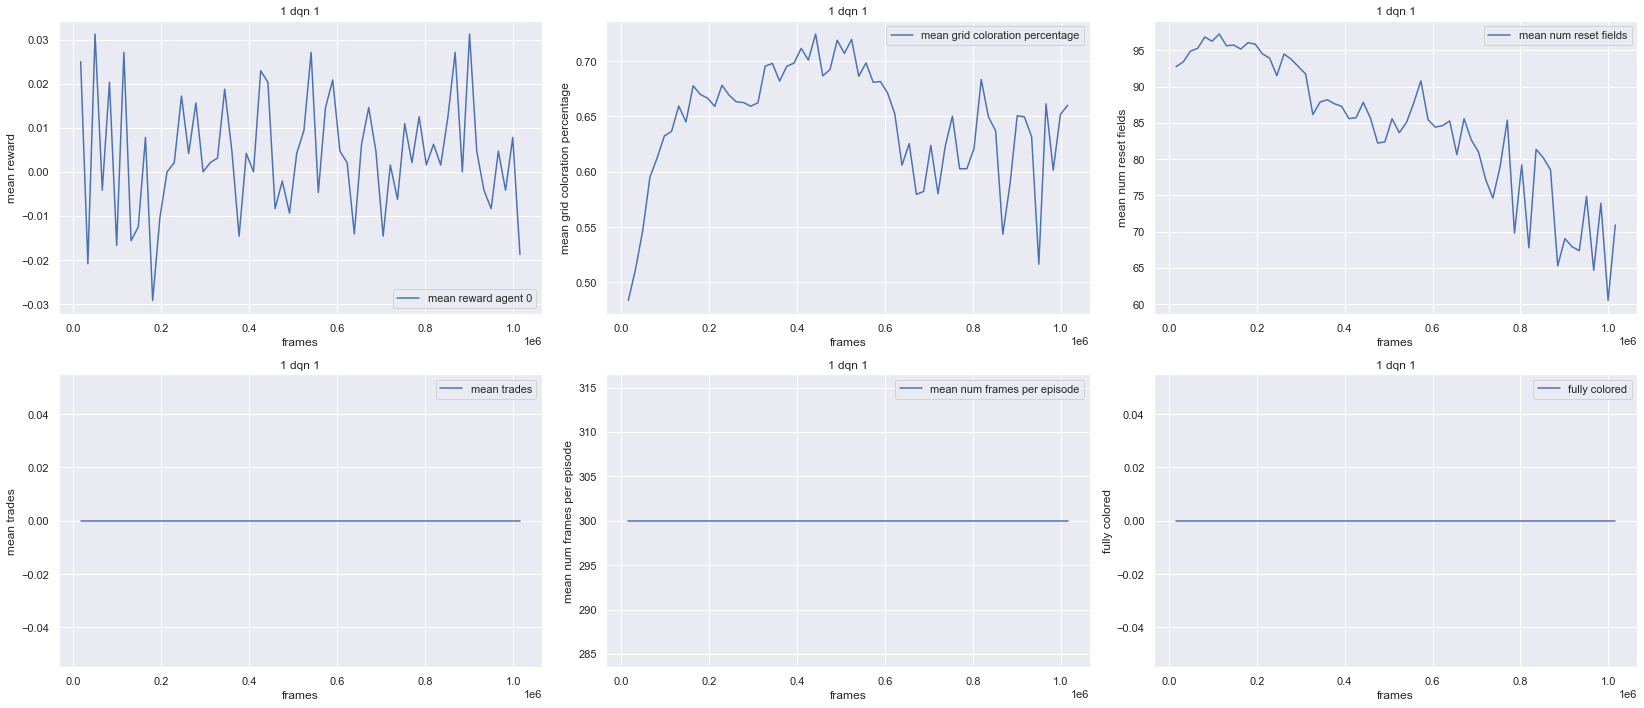

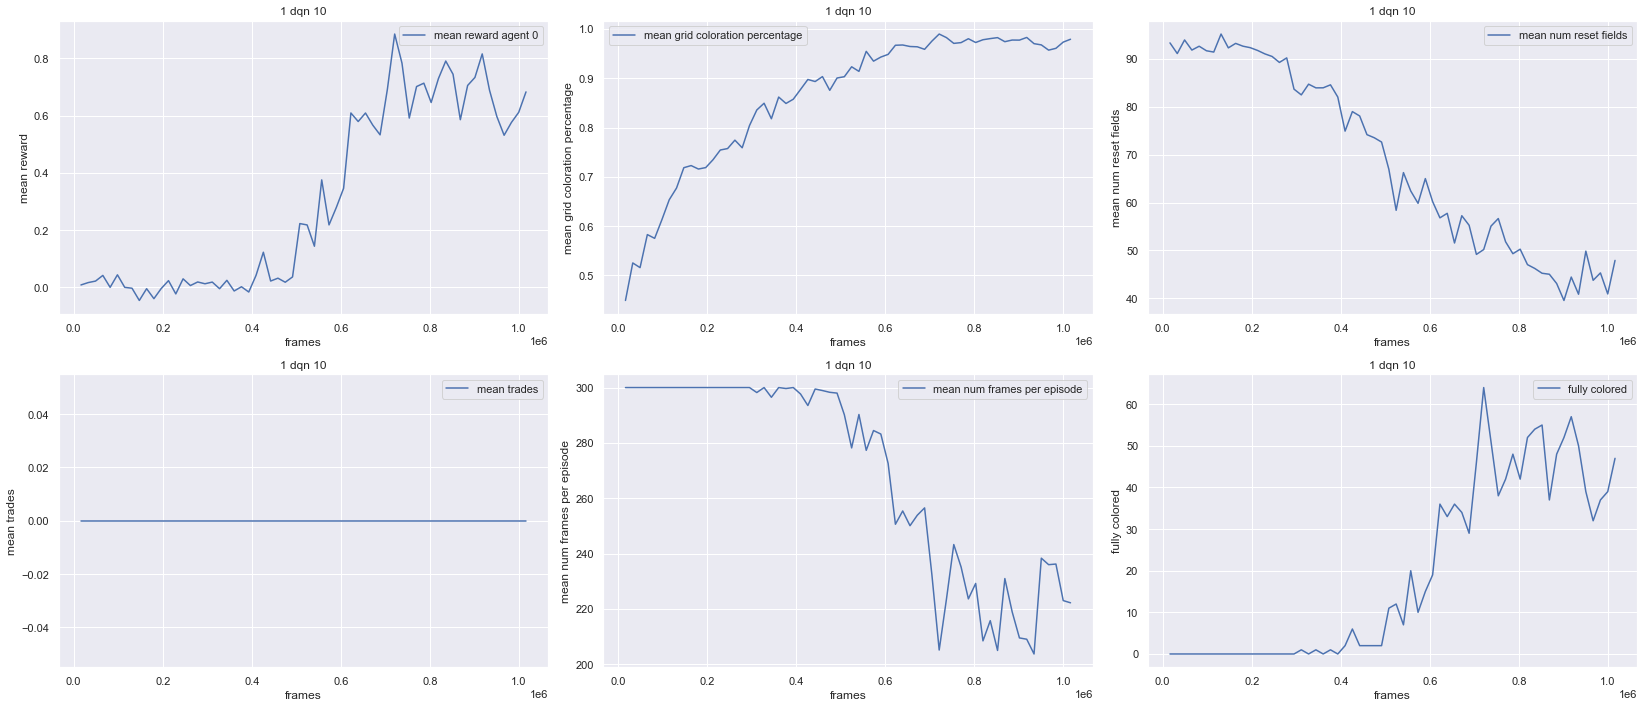

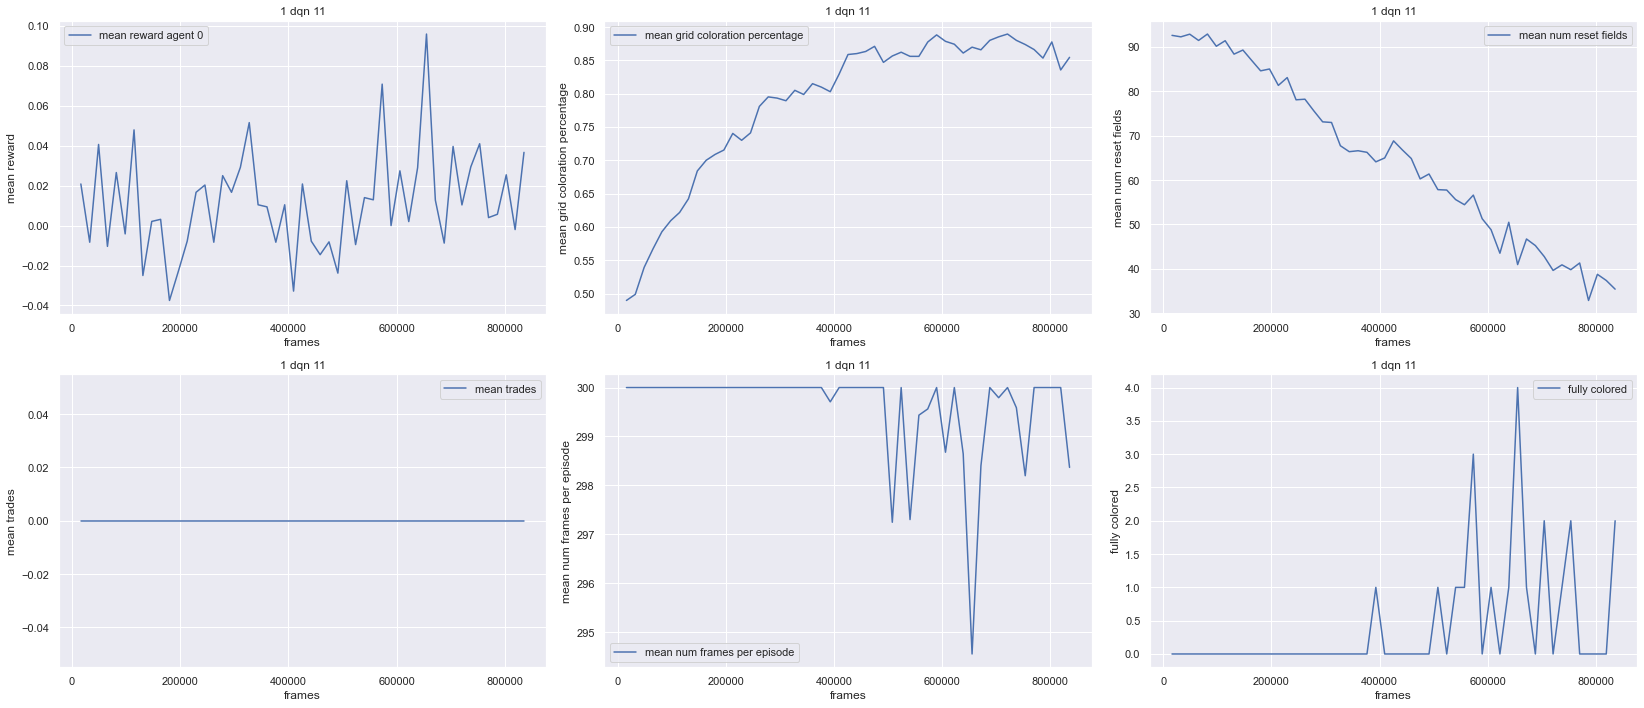

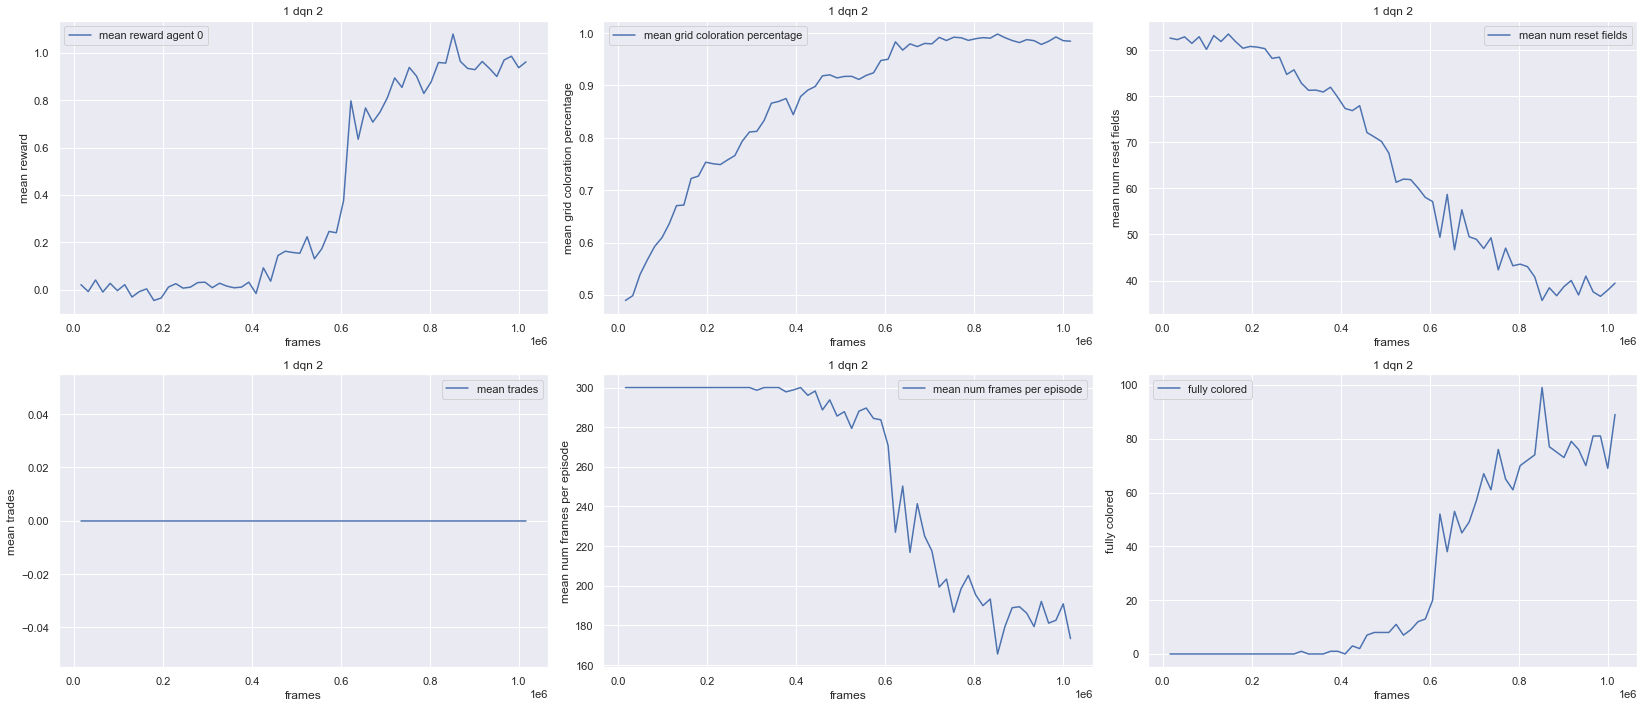

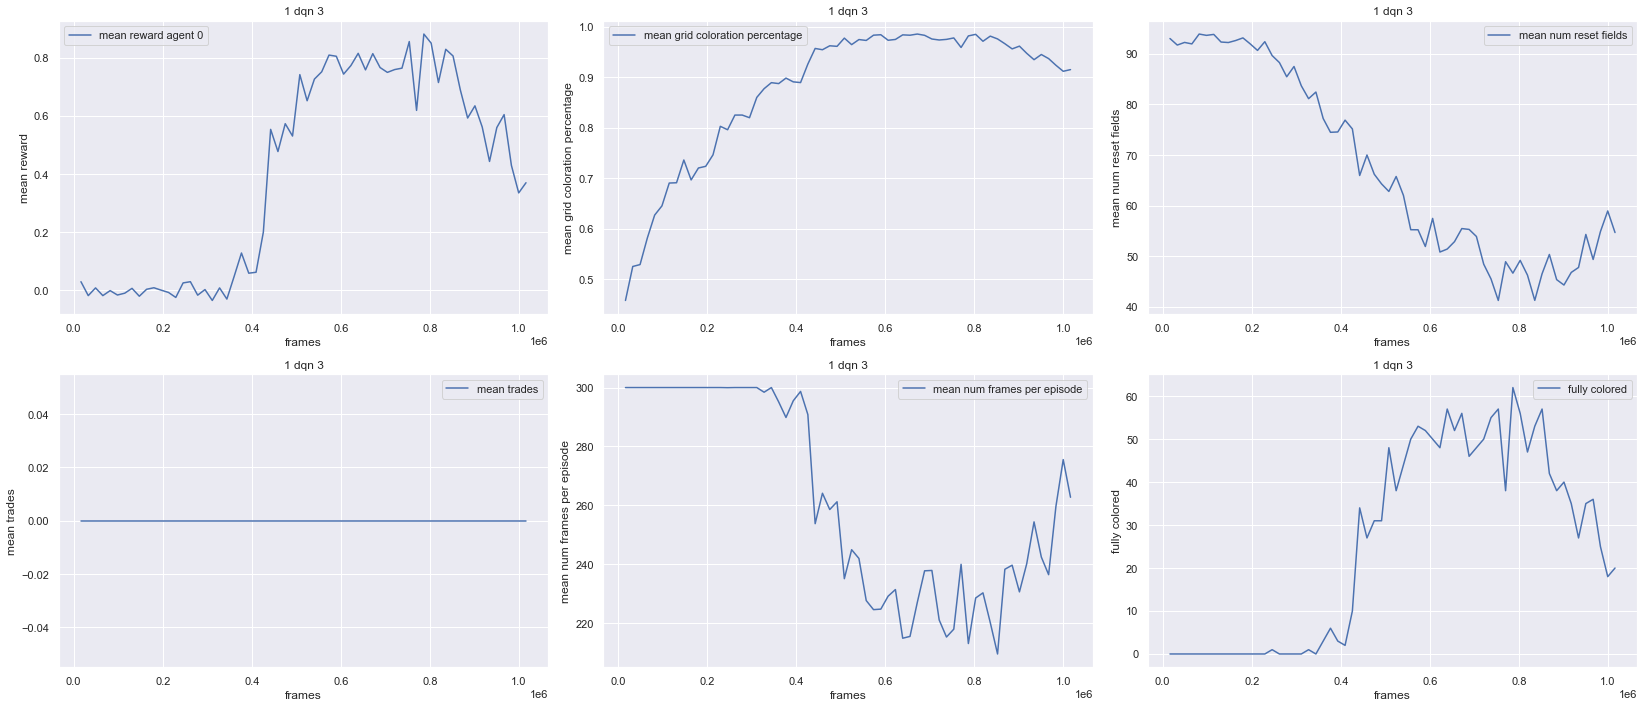

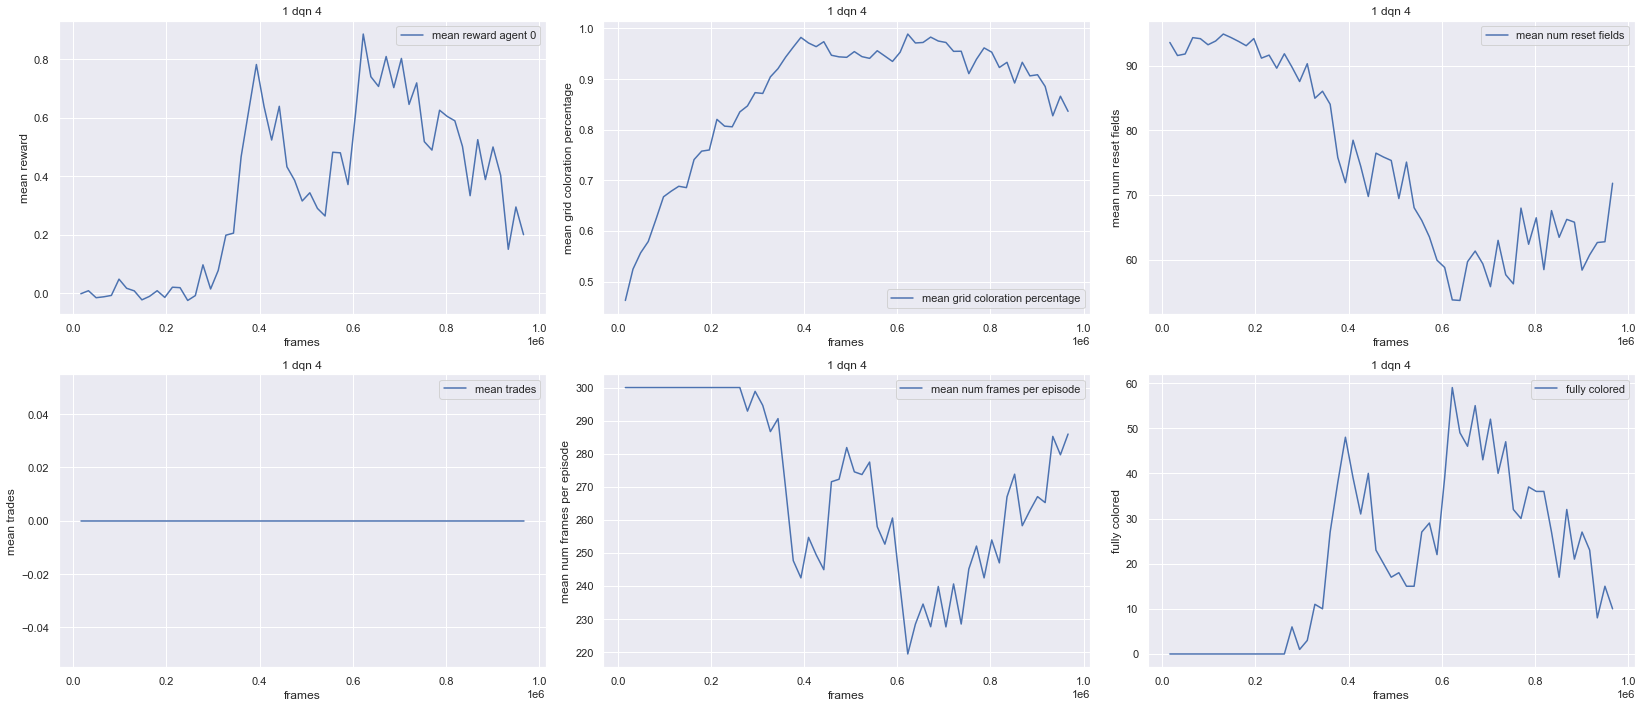

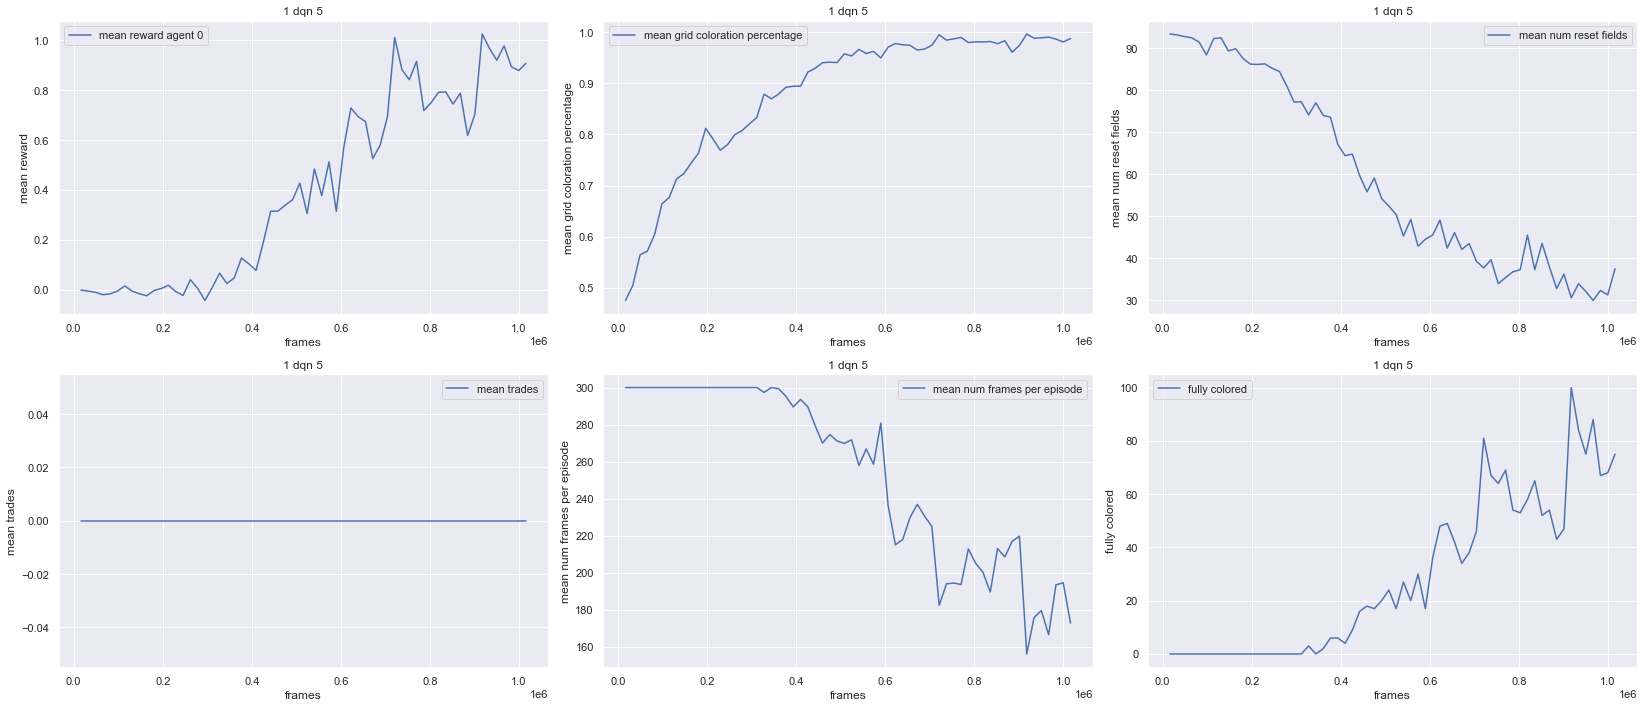

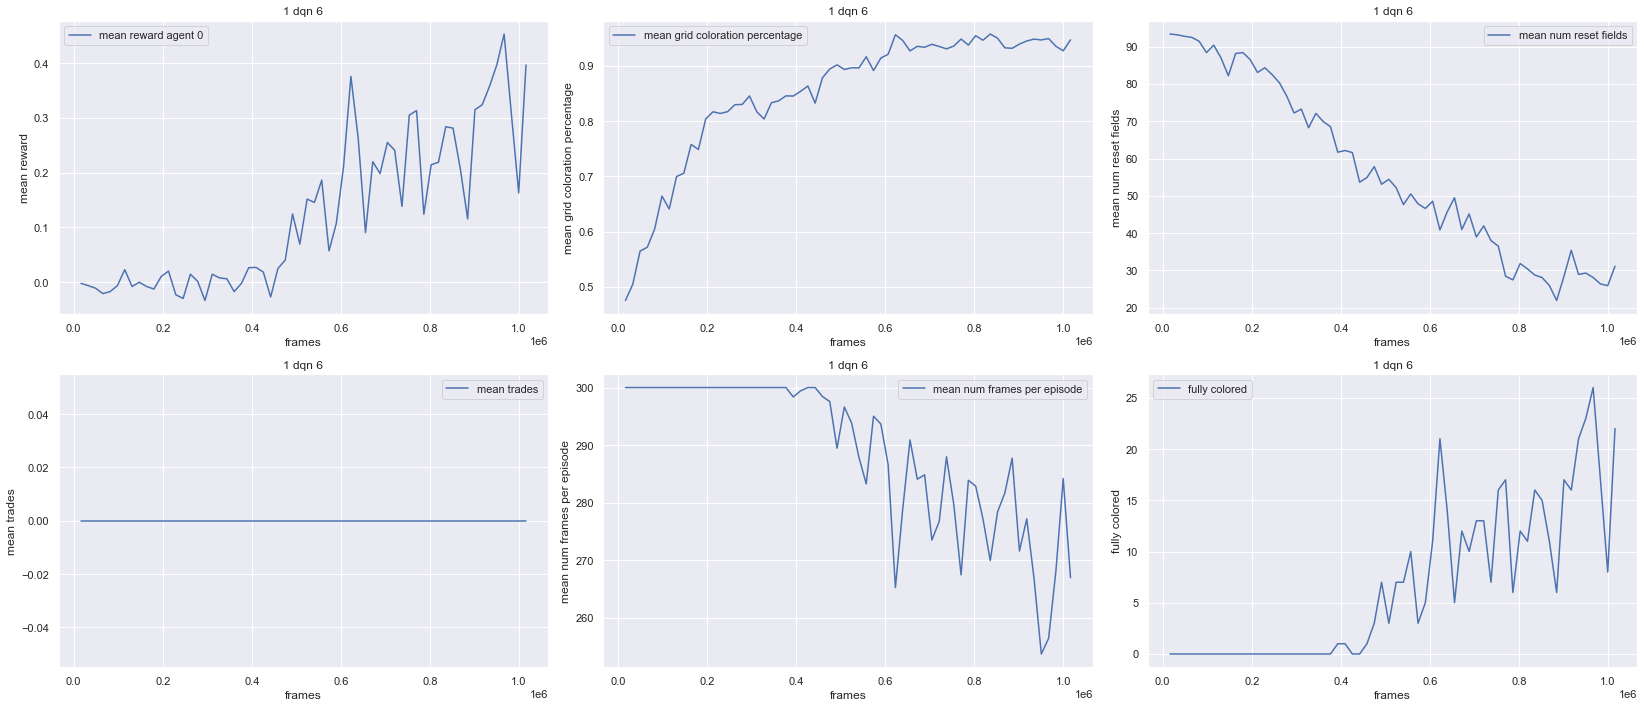

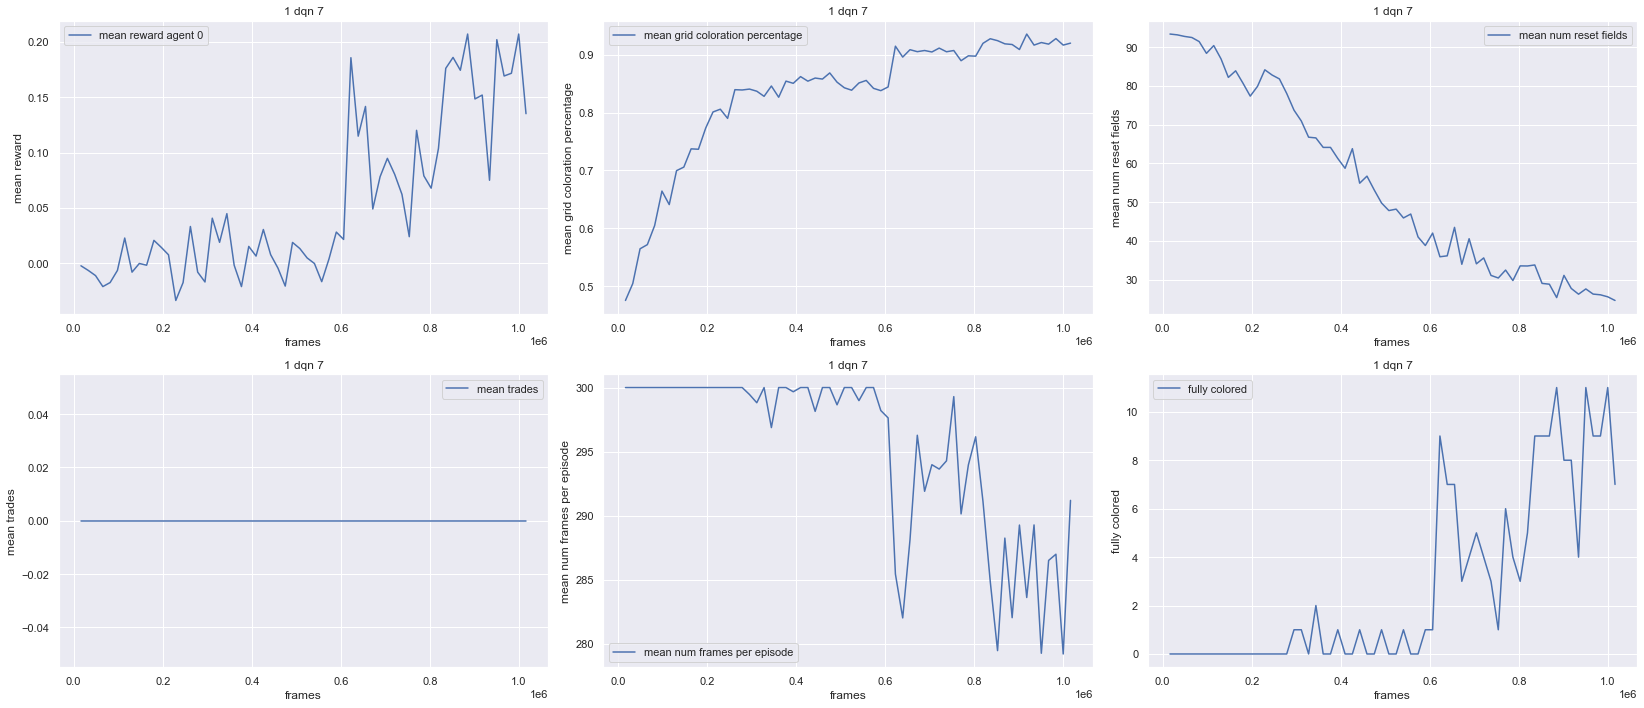

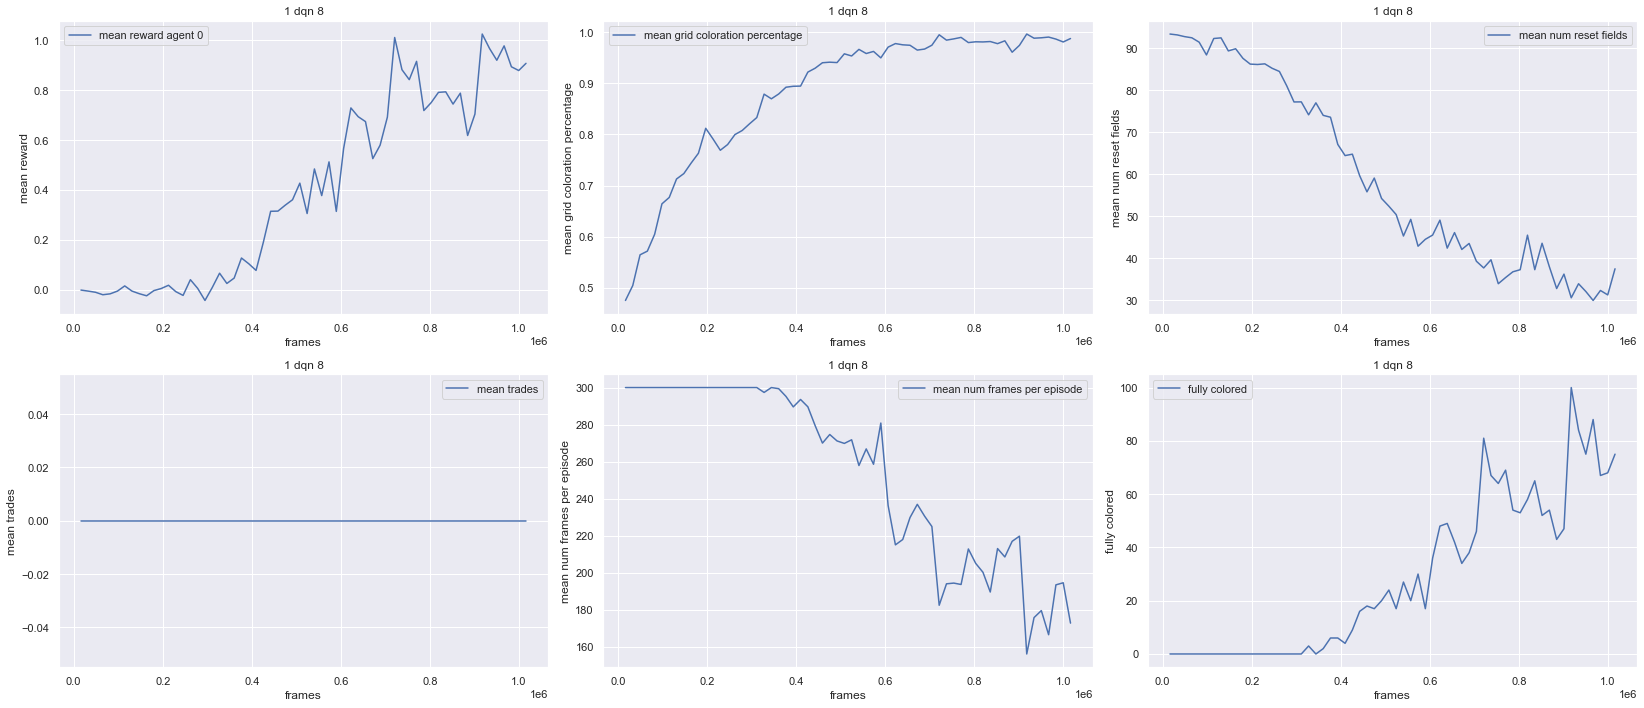

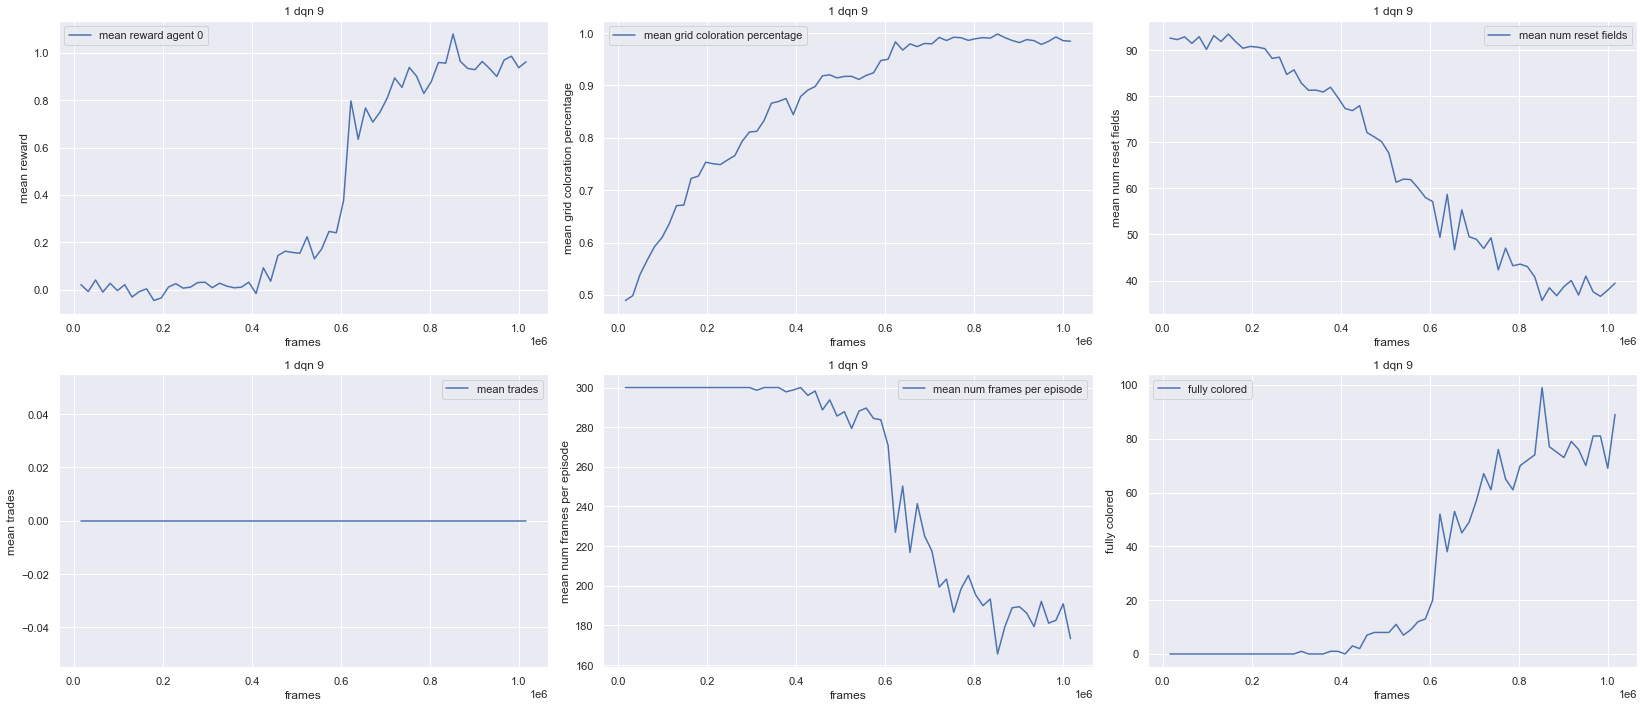

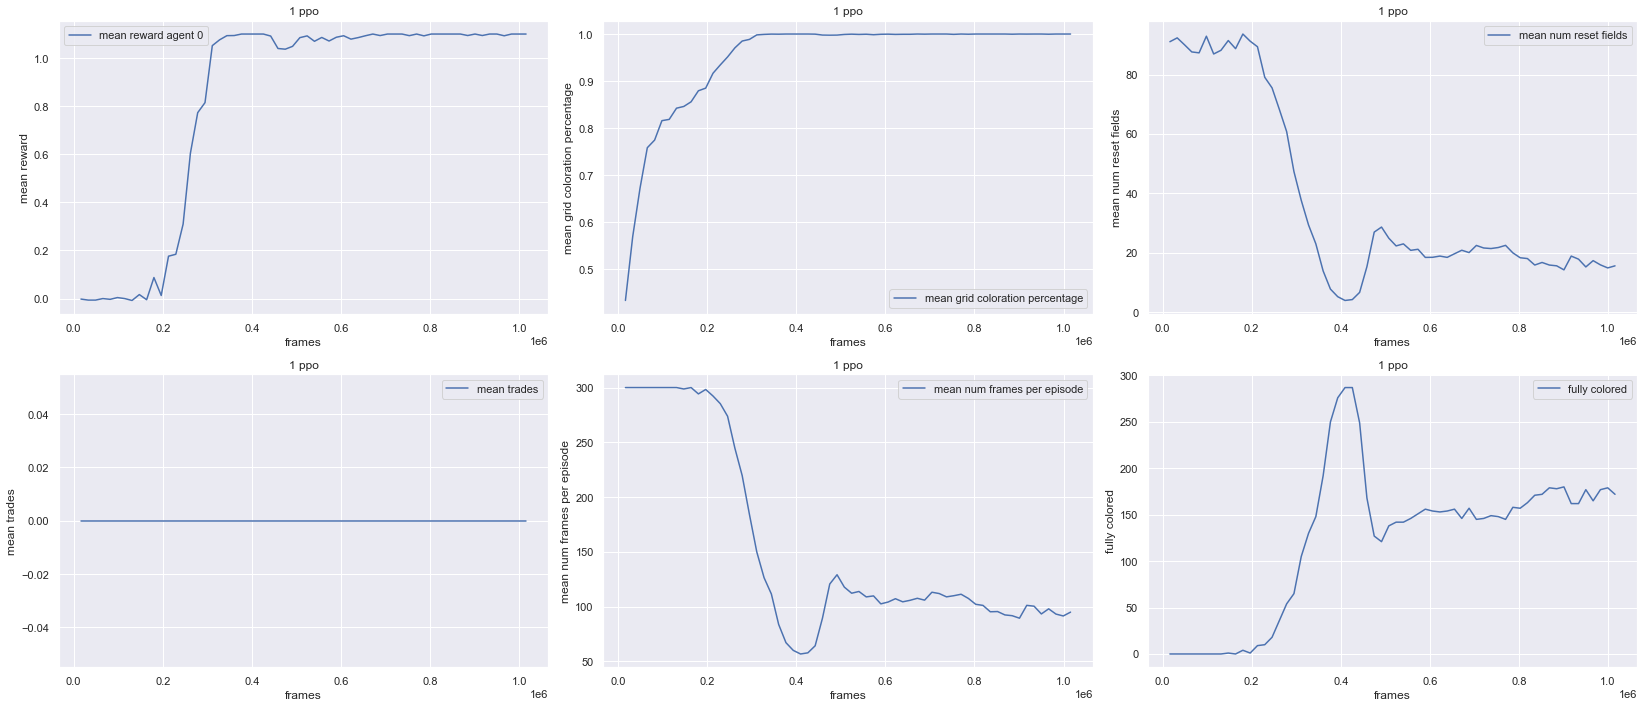

In [206]:
for setting in envs.keys():
    #define how many subplots
    sns.set_theme()
    max_col = 3
    f, axes = plt.subplots(nrows=2, ncols=max_col, figsize=(23, 10)) #, sharex=True
    col = 0
    row = 0
    title = " ".join(setting.split("-"))
    for key in keys:
        y_label = " ".join(key.split("_"))
        g = sns.lineplot(data=lf_settings_dicts[setting+"_"+key], x="frames", y=key, hue="setting", ax=axes[row, col])
        g.set(ylabel=y_label, title=title)

        #beatify plot legend labels
        _, labels = g.get_legend_handles_labels()
        for index, label in enumerate(labels):
            new_label = " ".join(label.split(setting+"_")[1].split("_"))
            labels[index] = new_label
        g.legend(labels=labels)

        col += 1
        if col == max_col:
            row += 1
            col = 0

    # plt.setp(axes)
    plt.title(title)
    plt.tight_layout()

In [207]:
def multiplot(columns_list, key):
    sns.set_theme(style="dark")

    # print(market_settings)
    for columns in columns_list:
        if not any("frames" in setting_col for setting_col in columns):
            # print(setting)
            columns.append(get_frames_col(df))

        df_complete = df[columns].copy()
        lf_complete = get_longform(df_complete, key)

        if any("agent_0" in column for column in columns):
            agent_zero_cols = [col for col in columns if "agent_0" in col or "frames" in col]
            # other_agents_cols = [col for col in columns if not "agent_0" in col or "frames" in col]
            df_filtered = df[agent_zero_cols].copy()
            lf_filtered = get_longform(df_filtered, key)
            
            # Plot each year's time series in its own facet
            g = sns.relplot(
                data=lf_filtered,
                x="frames", y=key, col="setting", hue="setting",
                kind="line", palette="crest", linewidth=2, zorder=5,
                col_wrap=2, height=5, aspect=3, legend=False
            )
        else:
            # Plot each year's time series in its own facet
            g = sns.relplot(
                data=lf_complete,
                x="frames", y=key, col="setting", hue="setting",
                kind="line", palette="crest", linewidth=4, zorder=5,
                col_wrap=2, height=5, aspect=3, legend=False
            )


        # Iterate over each subplot to customize further
        for s, ax in g.axes_dict.items():
            title = " ".join(s.split("_mean")[0].split("-"))
            # s=current plot!! Add the title as an annotation within the plot
            ax.text(.7, .85, title, transform=ax.transAxes, fontweight="bold")
            if "agent_0" in s: # check if more agent infos are available and plot them too!
                # in this case the agents have different values -> show all 
                # Plot every line greyed in the background
                setting = s.split("_agent")[0]
                lf_contains_agent = lf_complete[lf_complete['setting'].str.contains(setting)]
                lf_does_not_contain_agent = lf_complete[~lf_complete['setting'].str.contains(setting)]
                sns.lineplot(
                    data=lf_contains_agent, x="frames", y=key, zorder=5,
                    linewidth=2, ax=ax, hue="setting"
                )
                # Plot every line greyed in the background
                sns.lineplot(
                    data=lf_does_not_contain_agent, x="frames", y=key, units="setting",
                    estimator=None, color=".7", linewidth=1, ax=ax
                )
            else:
                sns.lineplot(
                    data=lf_complete, x="frames", y=key, units="setting",
                    estimator=None, color=".7", linewidth=1, ax=ax
                )

        # Reduce the frequency of the x axis ticks
        ax.set_xticks(ax.get_xticks()[::2])

        # Tweak the supporting aspects of the plot
        g.set_titles("")
        g.set_axis_labels("", key)
        # g.tight_layout()